In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def find_src(global_point, local_point):
    x, y, a = local_point.T
    x1, y1, a1 = global_point.T
    A = (a1 - a) % (2 * np.pi)
    X = x1 - x * np.cos(A) + y * np.sin(A)
    Y = y1 - x * np.sin(A) - y * np.cos(A)
    return np.array([X, Y, A]).T

# Local points

In [3]:
points_count = 1000
local_linear_noise = 1
local_angular_noise = np.pi / 12
local_mean = np.array([10, 10, np.pi/3])
global_linear_noise = 1
global_angular_noise = np.pi / 6
global_mean = np.array([0, 0, 0])

In [4]:
def generate_random_points(mean, linear_noise, angular_noise, points_count):
    x = mean[0] + np.random.randn(points_count) * linear_noise
    y = mean[1] + np.random.randn(points_count) * linear_noise
    angle = mean[2] + np.random.randn(points_count) * angular_noise
    return np.array([x, y, angle]).T

In [65]:
def show_points(points, new_figure=True, color="black"):
    if new_figure:
        plt.figure(dpi=150)
    plt.quiver(points[:, 0], points[:, 1], np.cos(points[:, 2]), np.sin(points[:, 2]), color=color)
    plt.gca().set_aspect("equal")

In [66]:
local_points = generate_random_points(local_mean, local_linear_noise, local_angular_noise, points_count)
global_points = generate_random_points(global_mean, global_linear_noise, global_angular_noise, points_count)
source_points = find_src(global_points, local_points)

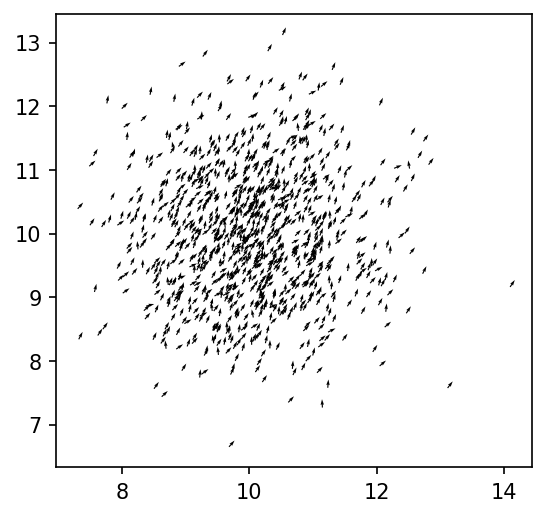

In [67]:
show_points(local_points)

# Lie local features

In [8]:
from liegroups.numpy import SE2

In [9]:
def matrix_from_point(point):
    matrix = np.eye(3)
    matrix[0, 2] = point[0]
    matrix[1, 2] = point[1]
    matrix[0, 0] = np.cos(point[2])
    matrix[0, 1] = -np.sin(point[2])
    matrix[1, 0] = np.sin(point[2])
    matrix[1, 1] = np.cos(point[2])
    return matrix

def point_from_matrix(matrix):
    x = matrix[0, 2]
    y = matrix[1, 2]
    angle = np.arctan2(matrix[1, 0], matrix[1, 1])
    return np.array([x, y, angle]).T

In [10]:
def make_lie_covariance(linear_noise, angular_noise):
    covariace = np.zeros((3, 3))
    covariace[0, 0] = linear_noise ** 2
    covariace[1, 1] = linear_noise ** 2
    covariace[2, 2] = angular_noise ** 2
    return covariace

In [11]:
def calculate_source_covariance(local_covariance, global_covariance, local_matrix, global_matrix):
    inverse_local_se2 = SE2.from_matrix(np.linalg.inv(local_matrix), normalize=True)
    inverse_local_adjoint = np.linalg.inv(inverse_local_se2.adjoint())
    source_covariance = inverse_local_adjoint @ (global_covariance + local_covariance) @ inverse_local_adjoint.T
    return source_covariance

In [12]:
def sample_from_se2(mean_matrix, covariance, point_count):
    cholesky_factor = np.linalg.cholesky(covariance)
    delta = np.random.randn(point_count, 3)
    delta = (cholesky_factor @ delta[:, :, None])[:, :, 0]
    delta_matrix = [SE2.exp(x).as_matrix() for x in delta]
    result_matrix = np.array([mean_matrix @ x for x in delta_matrix])
    x = result_matrix[:, 0, 2]
    y = result_matrix[:, 1, 2]
    angle = np.arctan2(result_matrix[:, 1, 0], result_matrix[:, 1, 1])
    return np.array([x, y, angle]).T

In [13]:
local_covariance = make_lie_covariance(local_linear_noise, local_angular_noise)
global_covariance = make_lie_covariance(global_linear_noise, global_angular_noise)
local_mean_matrix = matrix_from_point(local_mean)
global_mean_matrix = matrix_from_point(global_mean)
source_mean_matrix = matrix_from_point(find_src(global_mean, local_mean))
source_covariance = calculate_source_covariance(local_covariance, global_covariance,
                                                local_mean_matrix, global_mean_matrix)

In [14]:
print("Source covariance:\n", source_covariance)
point_from_matrix(source_mean_matrix)
print("Source mean:\n", point_from_matrix(source_mean_matrix))
point_from_matrix(source_mean_matrix)

Source covariance:
 [[ 36.26945973 -34.26945973   3.42694597]
 [-34.26945973  36.26945973  -3.42694597]
 [  3.42694597  -3.42694597   0.3426946 ]]
Source mean:
 [-13.66025404   3.66025404  -1.04719755]


array([-13.66025404,   3.66025404,  -1.04719755])

In [15]:
lie_sampled_source_points = sample_from_se2(source_mean_matrix, source_covariance, 1000)

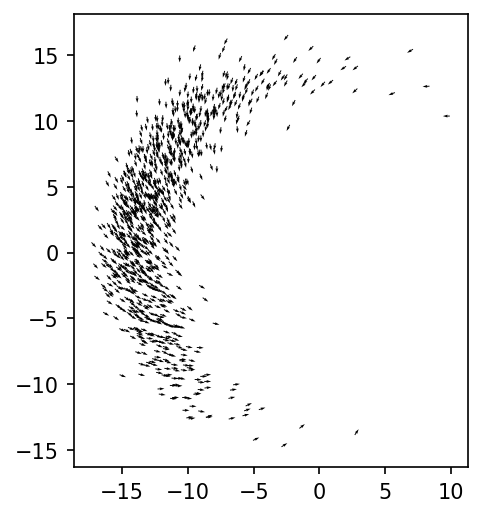

In [16]:
show_points(lie_sampled_source_points)

# Finding parameters

In [20]:
import torch
import torch.nn as nn
import tqdm

In [21]:
import sys
if ".." not in sys.path:
    sys.path.append("..")
import mvae
import mvae.models
import mvae.models.pose_distributions

In [22]:
torch.random.manual_seed(0)
pose_distribution = mvae.models.pose_distributions.Se2PoseDistribution()
logvar = nn.Parameter(torch.randn((1, pose_distribution.logvar_dimension), dtype=torch.float))
mean = nn.Parameter(torch.randn((1, pose_distribution.mean_dimension), dtype=torch.float))
optimizer = torch.optim.Adam([mean, logvar], lr=5e-1)
# optimizer = torch.optim.SGD([mean, logvar], lr=1e-1)

In [23]:
x = source_points[:, 0]
y = source_points[:, 1]
ca = np.cos(source_points[:, 2])
sa = np.sin(source_points[:, 2])
data_points = np.array([x, y, ca, sa]).T.astype(np.float32)[:100]
data_points = torch.from_numpy(data_points)

In [24]:
loss_history = []
for i in tqdm.tqdm(range(1000)):
    optimizer.zero_grad()
    loss = pose_distribution.log_prob((data_points[:, :2], data_points[:, 2:]), mean, logvar).mean()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
print(loss.item())
print(mean)
print(logvar)

100%|██████████| 1000/1000 [00:04<00:00, 244.89it/s]

4.482662200927734
Parameter containing:
tensor([[-13.9788,   3.0700,   2.0057,  -3.3060]], requires_grad=True)
Parameter containing:
tensor([[ 0.8472,  0.6531, -1.0486, -0.1283, -2.5504,  2.5458]],
       requires_grad=True)


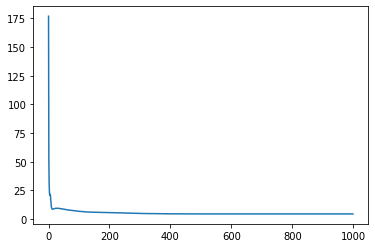

In [25]:
plt.plot(loss_history)

In [26]:
matrix = pose_distribution.get_sigma_matrix(logvar)[0].detach().cpu().numpy()
covariance = matrix @ matrix.T
mean_point = mean.detach().cpu().numpy()[0]
mean_point = np.array([mean_point[0], mean_point[1], np.arctan2(mean_point[3], mean_point[2])]).T
print(mean_point)

[-13.978828    3.0700095  -1.0254787]


In [27]:
print("Source covariance:\n", covariance)
print("Source mean:\n", mean_point)

Source covariance:
 [[ 38.68515    -35.0169       3.5674326 ]
 [-35.0169      35.18628     -3.4142318 ]
 [  3.5674326   -3.4142318    0.35042992]]
Source mean:
 [-13.978828    3.0700095  -1.0254787]


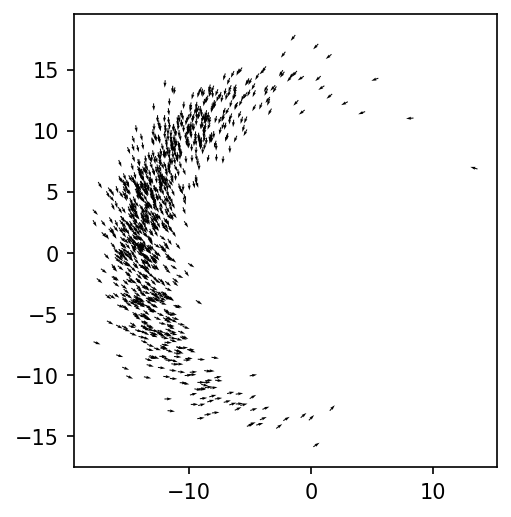

In [28]:
show_points(sample_from_se2(matrix_from_point(mean_point), covariance, 1000))

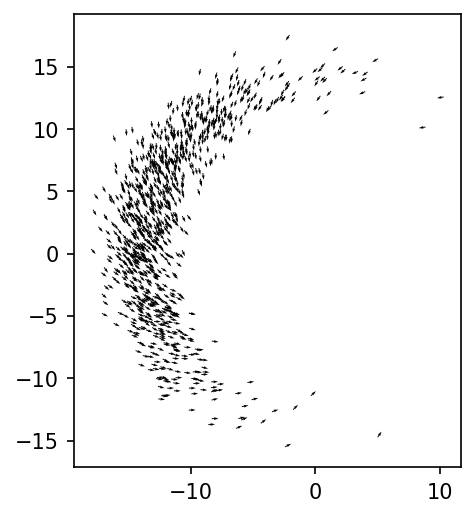

In [29]:
show_points(source_points)

# Multi head loss

In [105]:
source_mean_matrix1 = matrix_from_point(np.array([0, 0, 0]))
cholesky_factor = np.array([[1, 1, 10], [0, 1, 1], [0, 0, 0.3]])
source_covariance1 = cholesky_factor @ cholesky_factor.T

In [106]:
sampled1 = sample_from_se2(source_mean_matrix1, source_covariance1, 1000)

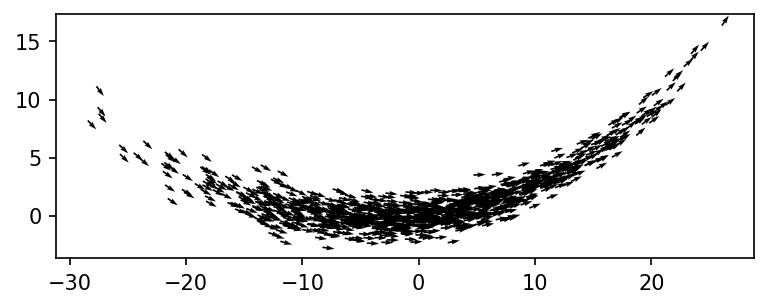

In [107]:
show_points(sampled1)

In [108]:
source_mean_matrix2 = matrix_from_point(np.array([10, 15, -np.pi / 2]))
cholesky_factor = np.array([[1, 1, 10], [0, 1, 1], [0, 0, 0.3]])
source_covariance2 = cholesky_factor @ cholesky_factor.T

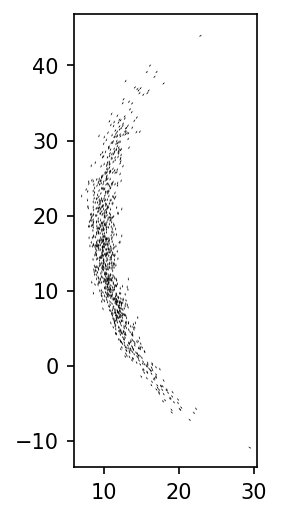

In [109]:
sampled2 = sample_from_se2(source_mean_matrix2, source_covariance2, 1000)
show_points(sampled2)

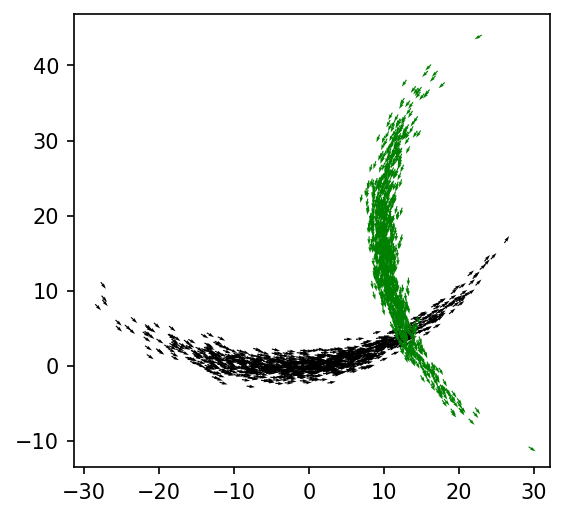

In [110]:
show_points(sampled1)
show_points(sampled2, False, "green")

In [111]:
def calculate_joint_covariance(covariance1, covariance2):
    return np.linalg.inv(np.linalg.inv(covariance1) + np.linalg.inv(covariance2))

def calculate_joint_mean(mean1, covariance1, mean2, covariance2):
    covariance = calculate_joint_covariance(covariance1, covariance2)
    log_mean1 = SE2.from_matrix(mean1).log()
    log_mean2 = SE2.from_matrix(mean2).log()
    log_mean = covariance @ np.linalg.inv(covariance1) @ log_mean1 +\
        covariance @ np.linalg.inv(covariance2) @ log_mean2
    return SE2.exp(log_mean).as_matrix()

In [112]:
joint_covariance = calculate_joint_covariance(source_covariance1, source_covariance2)
joint_mean = calculate_joint_mean(source_mean_matrix1, source_covariance1,
                                  source_mean_matrix2, source_covariance2)
joint_sampled = sample_from_se2(joint_mean, joint_covariance, 1000)

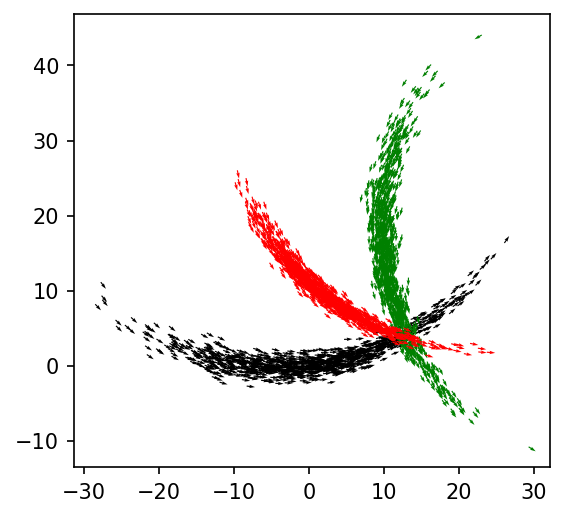

In [113]:
show_points(sampled1)
show_points(sampled2, False, "green")
show_points(joint_sampled, False, "red")

In [114]:
def calculate_joint_mean_second(mean1, covariance1, mean2, covariance2):
    covariance = calculate_joint_covariance(covariance1, covariance2)
    delta = np.linalg.inv(mean1) @ mean2
    log_mean = covariance @ np.linalg.inv(covariance1) @ SE2.from_matrix(delta).log()
    return mean1 @ SE2.exp(log_mean).as_matrix()

In [115]:
joint_covariance2 = calculate_joint_covariance(source_covariance1, source_covariance2)
joint_mean2 = calculate_joint_mean_second(source_mean_matrix1, source_covariance1,
                                  source_mean_matrix2, source_covariance2)
joint_sampled2 = sample_from_se2(joint_mean2, joint_covariance2, 1000)

In [116]:
joint_mean2

array([[ 0.70710678,  0.70710678,  1.89339828],
       [-0.70710678,  0.70710678,  9.57106781],
       [ 0.        ,  0.        ,  1.        ]])

In [117]:
joint_mean

array([[ 0.70710678,  0.70710678,  1.89339828],
       [-0.70710678,  0.70710678,  9.57106781],
       [ 0.        ,  0.        ,  1.        ]])

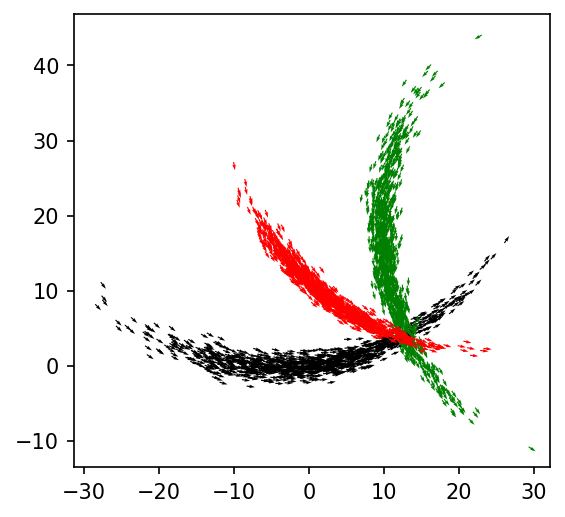

In [118]:
show_points(sampled1)
show_points(sampled2, False, "green")
show_points(joint_sampled2, False, "red")